/tmp/ipykernel_479041/2593611582.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', len(unique_groups))  # 使用 tab10 颜色方案


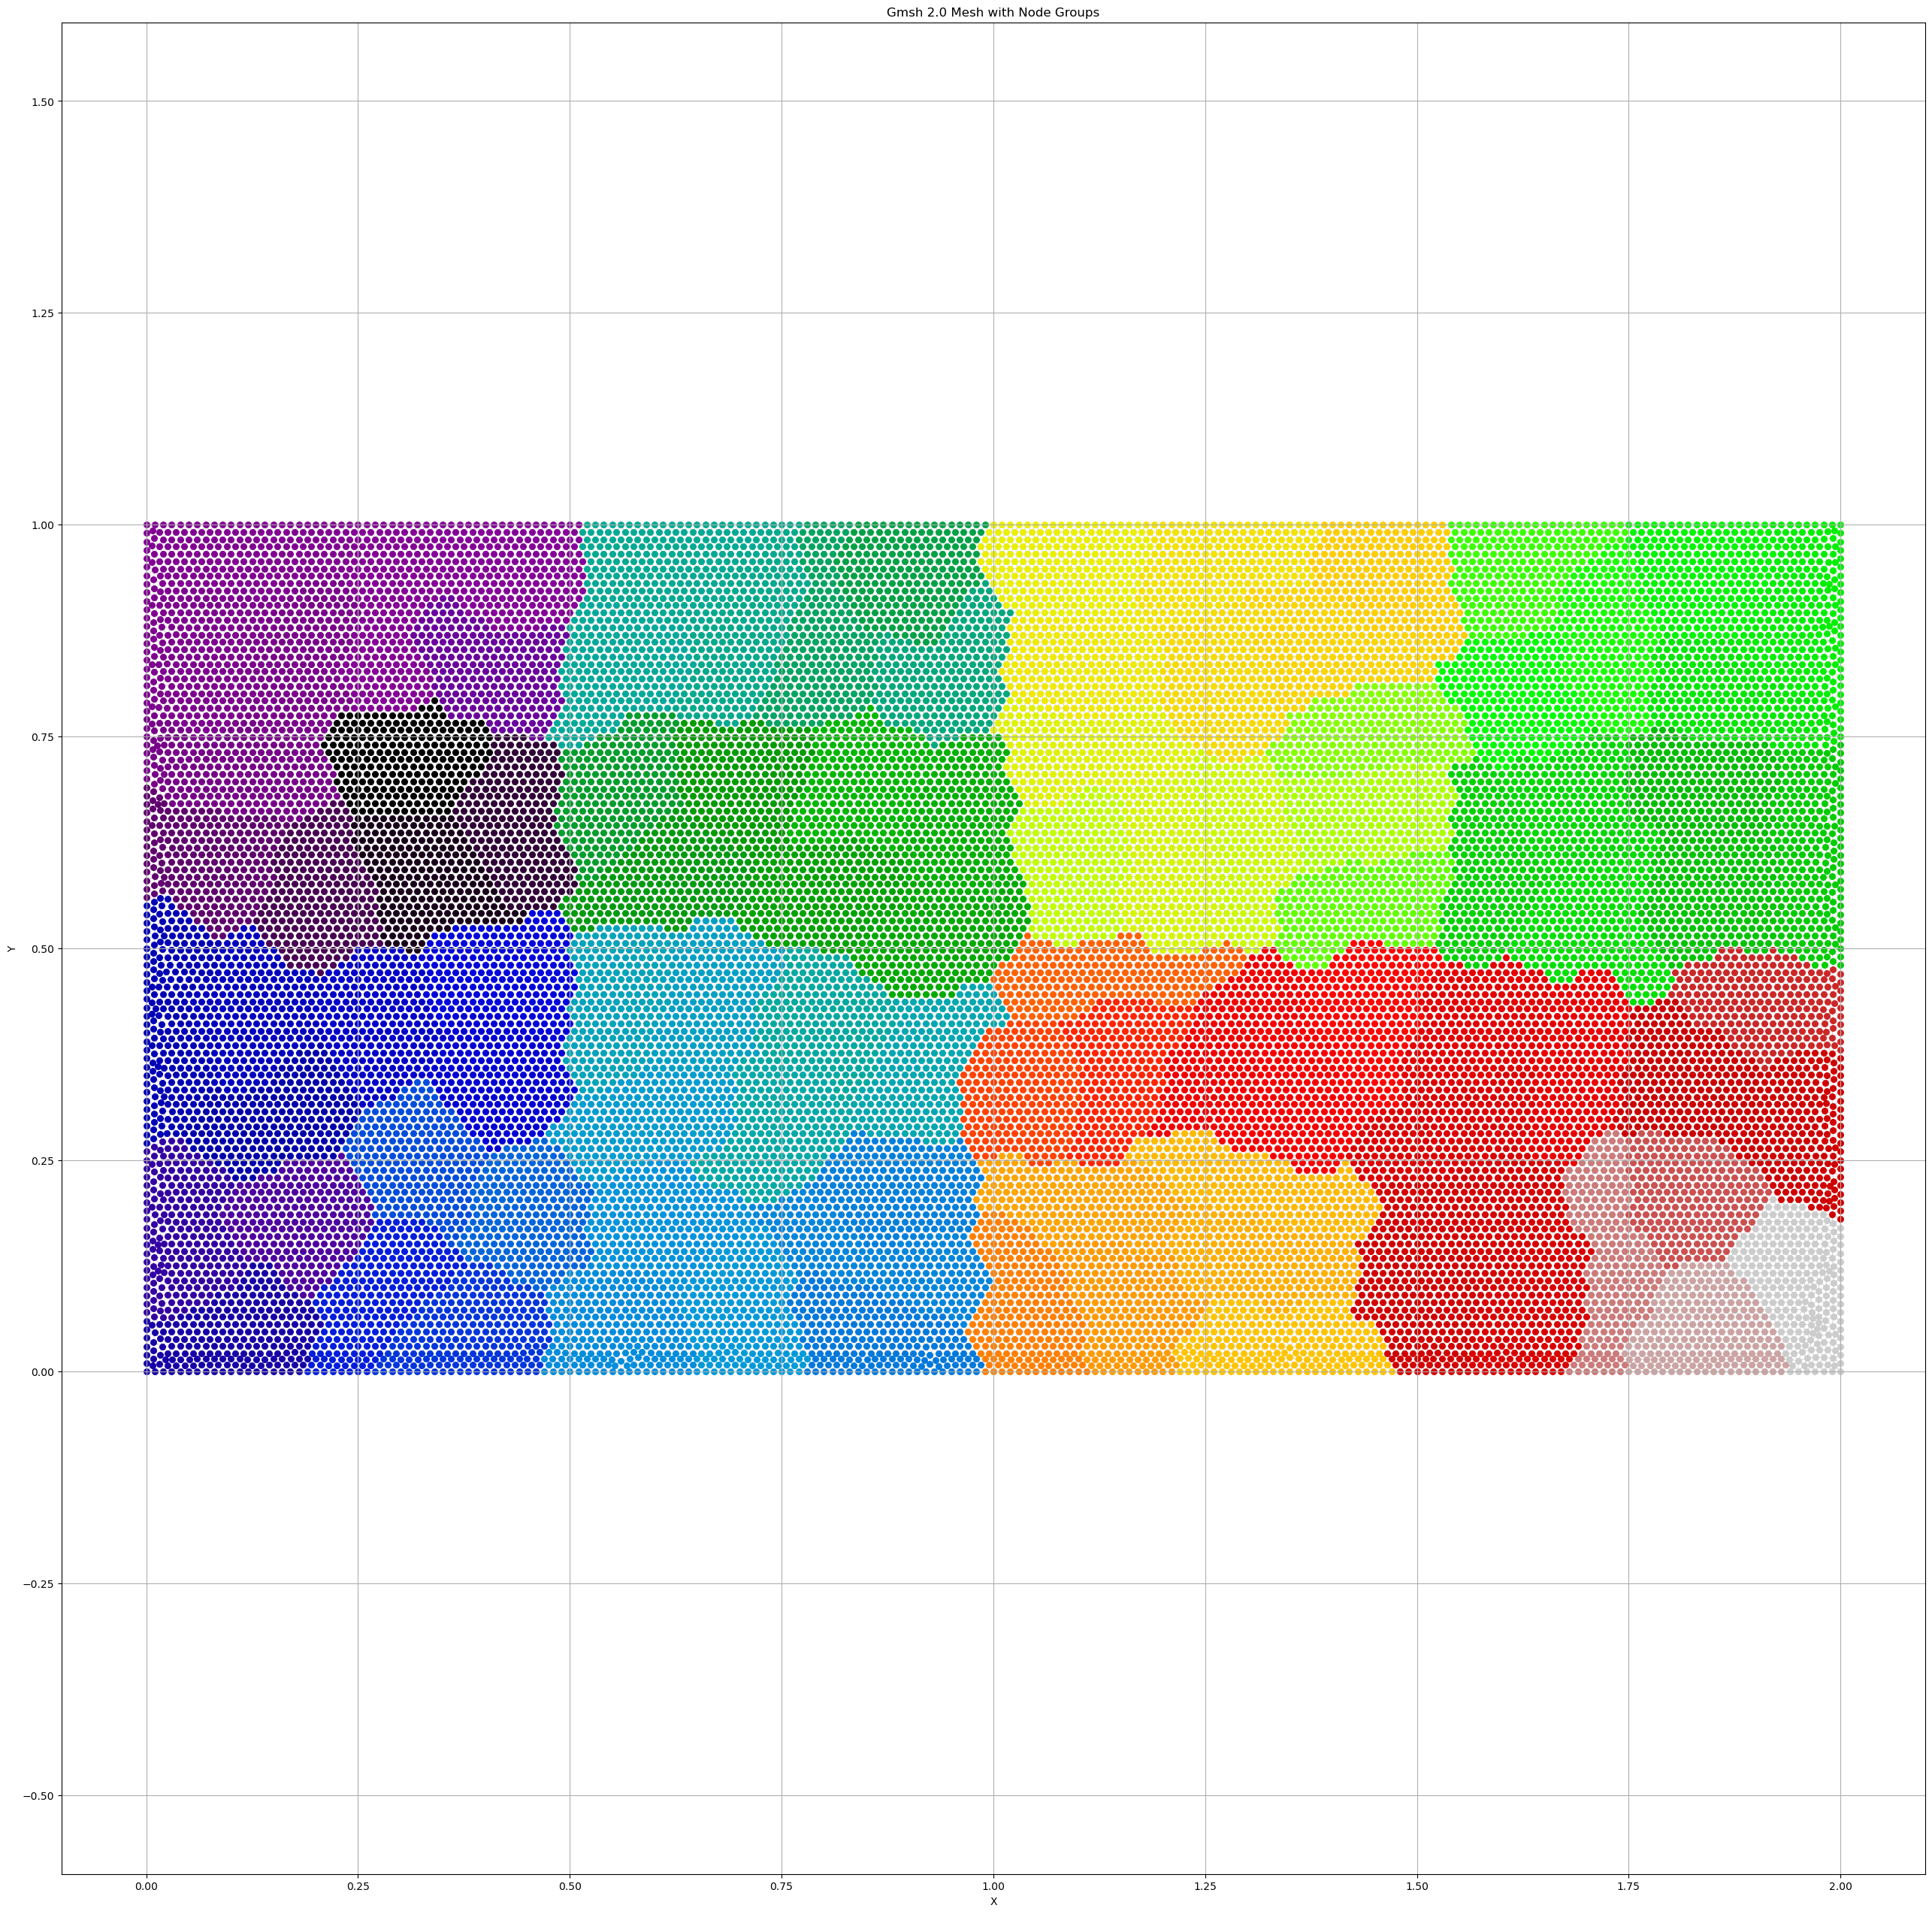

In [1]:
import meshio
import matplotlib.pyplot as plt
import numpy as np

# 读取 .msh 文件
mesh = meshio.read("data/rect.msh")  

# 提取节点坐标和三角形元素
points = mesh.points
x = points[:, 0]  # x 坐标
y = points[:, 1]  # y 坐标
triangles = mesh.cells_dict.get("triangle", None)
if triangles is None:
    raise ValueError("文件中没有三角形元素，请检查网格类型")

# 读取分组文件
group_file = "build/src/clustering.txt"  
groups = []
with open(group_file, "r") as f:
    for line in f:
        groups.append(int(line.strip()))  # 假设每行是一个整数

# 检查节点数量是否匹配
if len(groups) != len(points):
    raise ValueError(f"分组文件中的节点数 ({len(groups)}) 与 .msh 文件中的节点数 ({len(points)}) 不匹配")

# 可视化
plt.figure(figsize=(32, 32))

# 绘制网格
plt.triplot(x, y, triangles, color='gray', linewidth=0.5, alpha=0.5)

# 按组别绘制节点，使用不同颜色
unique_groups = np.unique(groups)  # 获取所有唯一的组别
colors = plt.cm.get_cmap('nipy_spectral', len(unique_groups))  # 使用 tab10 颜色方案
for i, group in enumerate(unique_groups):
    mask = np.array(groups) == group  # 选择属于当前组的节点
    plt.scatter(x[mask], y[mask], c=[colors(i)], label=f"Group {group}", s=30)

# 添加图例和装饰
plt.title("Gmsh 2.0 Mesh with Node Groups")
plt.xlabel("X")
plt.ylabel("Y")
# plt.legend()
plt.axis('equal')  # 保持纵横比一致
plt.grid(True)
plt.show()

In [6]:
import os
print(os.path.exists("data/rect"))

True


In [3]:
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
import numpy as np
data2 = np.array([0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25])
row2 = np.array([0, 1, 2, 3, 4, 5, 6, 7])
col2 = np.array([0, 1, 2, 3, 4, 5, 6, 7])
B = csr_matrix((data2, (row2, col2)), shape=(8, 8))

data = np.array([0.25, -0.25, -0.25, 0.5, -0.25, 0.25, -0.25, -0.25, 0.5, -0.25, -0.25, 0.5, -0.25, -0.25, 0.25, -0.25, 0.5, -0.25, -0.25, 0.25])
row_indices = np.array([0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7])
col_indices = np.array([0, 1, 0, 1, 4, 2, 3, 2, 3, 6, 1, 4, 5, 4, 5, 3, 6, 7, 6, 7])
example_csr = csr_matrix((data, (row_indices, col_indices)), shape=(8, 8))
eigenvalues, eigenvectors = eigsh(example_csr, M=B, k=4, which='SA')
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

Eigenvalues: [-8.98066291e-19  2.22942671e-16  5.00000000e-01  5.00000000e-01]
Eigenvectors:
 [[ 0.71511222  0.39405734 -1.12479349 -0.26109949]
 [ 0.71511222  0.39405734 -0.56239674 -0.13054974]
 [-0.39405734  0.71511222 -0.26109949  1.12479349]
 [-0.39405734  0.71511222 -0.13054974  0.56239674]
 [ 0.71511222  0.39405734  0.56239674  0.13054974]
 [ 0.71511222  0.39405734  1.12479349  0.26109949]
 [-0.39405734  0.71511222  0.13054974 -0.56239674]
 [-0.39405734  0.71511222  0.26109949 -1.12479349]]


In [5]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix

def generate_poisson_matrix(n, h=1.0, output_file="poisson_matrix_data.txt"):
    """
    生成二维泊松问题五点差分正方形网格矩阵（全迪利克雷边界条件），
    并将 CSR 格式数据、行数和非零元素个数写入到文本文件。
    输出格式：第一行为行数和非零元，第二行为data数组，第三行为indices数组，第四行为indptr数组。
    
    参数：
        n (int): 网格在每个方向上的分割数（n x n 网格）。
        h (float): 网格步长，默认为 1.0（单位正方形）。
        output_file (str): 输出文件名，默认为 'poisson_matrix_data.txt'。
        
    返回：
        A (scipy.sparse.csr_matrix): 离散化的系数矩阵。
        b (numpy.ndarray): 右端向量（假设源项 f=0，边界条件 u=0）。
    """
    # 内部网格点数 (n-1) x (n-1)
    N = (n - 1) * (n - 1)
    
    # 初始化稀疏矩阵（使用 lil_matrix 便于填充）
    A = lil_matrix((N, N))
    
    # 网格步长的平方倒数
    h2 = h * h
    
    # 填充矩阵
    for i in range(n - 1):
        for j in range(n - 1):
            # 当前网格点的索引（按行优先编号）
            idx = i * (n - 1) + j
            
            # 五点差分格式
            A[idx, idx] = 4  # 中心点
            if j > 0:
                A[idx, idx - 1] = -1  # 左边点
            if j < n - 2:
                A[idx, idx + 1] = -1  # 右边点
            if i > 0:
                A[idx, idx - (n - 1)] = -1  # 上边点
            if i < n - 2:
                A[idx, idx + (n - 1)] = -1  # 下边点
    
    # 转换为 CSR 格式
    A = A.tocsr()
    
    # 右端向量（假设 f=0，边界条件 u=0）
    b = np.zeros(N)
    
    # 打印 CSR 格式数据（新格式）
    # print(f"{A.shape[0]} {A.nnz}")
    # print(" ".join(map(str, A.data)))
    # print(" ".join(map(str, A.indices)))
    # print(" ".join(map(str, A.indptr)))
    
    # 将 CSR 数据写入文本文件（新格式）
    with open(output_file, 'w') as f:
        f.write(f"{A.shape[0]} {A.nnz}\n")
        f.write(" ".join([f"{x:.1f}" if x % 1 else f"{int(x)}" for x in A.data]) + "\n")
        f.write(" ".join(map(str, A.indices)) + "\n")
        f.write(" ".join(map(str, A.indptr)) + "\n")
    
    print(f"\n数据已写入文件: {output_file}")
    
    return A, b

# 示例用法
if __name__ == "__main__":
    n = 51  # 网格分割数（4x4 网格）
    h = 1.0 / n  # 网格步长
    output_file = "data/A.bin"
    A, b = generate_poisson_matrix(n, h, output_file)
    
    print("\n系数矩阵 A（密集格式，仅供参考）：")
    print(A.toarray())
    print("\n右端向量 b：")
    print(b)


数据已写入文件: data/A.bin

系数矩阵 A（密集格式，仅供参考）：
[[ 4. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  4.]]

右端向量 b：
[0. 0. 0. ... 0. 0. 0.]


In [4]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix

def generate_poisson_matrix_3d(n, h=1.0, output_file="poisson_matrix_3d_data.txt"):
    """
    Generate a 3D Poisson problem matrix using a seven-point stencil on a cubic grid
    with Dirichlet boundary conditions, and write CSR format data to a text file.
    Output format: First line contains number of rows and non-zero elements,
    second line contains data array, third line contains indices array,
    fourth line contains indptr array.

    Parameters:
        n (int): Number of subdivisions in each direction (n x n x n grid).
        h (float): Grid spacing, default is 1.0 (unit cube).
        output_file (str): Output file name, default is 'poisson_matrix_3d_data.txt'.

    Returns:
        A (scipy.sparse.csr_matrix): Discretized coefficient matrix.
        b (numpy.ndarray): Right-hand side vector (assuming source term f=0, boundary u=0).
    """
    # Number of interior grid points (n-1) x (n-1) x (n-1)
    N = (n - 1) * (n - 1) * (n - 1)
    
    # Initialize sparse matrix using lil_matrix for efficient filling
    A = lil_matrix((N, N))
    
    # Inverse of grid spacing squared
    h2 = h * h
    
    # Fill the matrix using seven-point stencil
    for i in range(n - 1):
        for j in range(n - 1):
            for k in range(n - 1):
                # Current grid point index (row-major ordering)
                idx = (i * (n - 1) + j) * (n - 1) + k
                
                # Seven-point stencil
                A[idx, idx] = 6  # Center point
                if j > 0:
                    A[idx, idx - 1] = -1  # Left point (y-direction)
                if j < n - 2:
                    A[idx, idx + 1] = -1  # Right point (y-direction)
                if i > 0:
                    A[idx, idx - (n - 1)] = -1  # Up point (x-direction)
                if i < n - 2:
                    A[idx, idx + (n - 1)] = -1  # Down point (x-direction)
                if k > 0:
                    A[idx, idx - (n - 1) * (n - 1)] = -1  # Front point (z-direction)
                if k < n - 2:
                    A[idx, idx + (n - 1) * (n - 1)] = -1  # Back point (z-direction)
    
    # Convert to CSR format
    A = A.tocsr()
    
    # Right-hand side vector (assuming f=0, boundary condition u=0)
    b = np.zeros(N)
    
    # Write CSR data to text file
    with open(output_file, 'w') as f:
        f.write(f"{A.shape[0]} {A.nnz}\n")
        f.write(" ".join([f"{x:.1f}" if x % 1 else f"{int(x)}" for x in A.data]) + "\n")
        f.write(" ".join(map(str, A.indices)) + "\n")
        f.write(" ".join(map(str, A.indptr)) + "\n")
    
    print(f"\nData written to file: {output_file}")
    
    return A, b

# Example usage
if __name__ == "__main__":
    n = 3  # Grid subdivisions (n x n x n grid)
    h = 1.0 / n  # Grid spacing
    output_file = "data/A_3d.bin"
    A, b = generate_poisson_matrix_3d(n, h, output_file)
    
    print("\nCoefficient matrix A (dense format, for reference):")
    print(A.toarray())
    print("\nRight-hand side vector b:")
    print(b)

IndexError: column index (8) out of bounds

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clusters(n, clustering_file="clustering.txt", output_file="clusters_plot.png"):
    """
    读取聚类结果并在正方形网格上绘制每个点的散点图，按聚类标签着色。
    
    参数：
        n (int): 网格在每个方向上的分割数（n x n 网格，内部点为 (n-1) x (n-1)）。
        clustering_file (str): 包含聚类标签的文件路径，每行一个整数。
        output_file (str): 输出图像的文件名，默认为 'clusters_plot.png'。
    """
    # 内部网格点数 (n-1) x (n-1)
    N = n - 1
    
    # 读取聚类标签
    with open(clustering_file, 'r') as f:
        labels = [int(line.strip()) for line in f]
    
    # 验证标签数量是否匹配网格点数
    if len(labels) != N * N:
        raise ValueError(f"聚类标签数量 ({len(labels)}) 与网格点数 ({N * N}) 不匹配")
    
    # 创建网格坐标
    x, y = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
    x = x.flatten()  # 展平为向量，按行优先
    y = y.flatten()
    
    # 获取唯一标签并为每个标签分配颜色
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels)
    colors = plt.cm.get_cmap('tab10', num_clusters)  # 使用 tab10 颜色图，支持最多10个聚类
    
    # 绘制散点图
    plt.figure(figsize=(8, 8))
    for idx, label in enumerate(unique_labels):
        mask = np.array(labels) == label
        plt.scatter(x[mask], y[mask], c=[colors(idx)], label=f'Cluster {label}', s=50)
    
    # 设置图形属性
    plt.title('Clustering on Square Grid')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('square')  # 保持正方形比例
    
    # 保存图像
    plt.savefig(output_file)
    plt.close()
    
    print(f"聚类图已保存至: {output_file}")

# 示例用法
if __name__ == "__main__":
 # 与之前的泊松矩阵示例保持一致
    plot_clusters(n, "build/src/clustering.txt", "clusters_plot.png")

聚类图已保存至: clusters_plot.png


/tmp/ipykernel_2398166/2952440922.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters)  # 使用 tab10 颜色图，支持最多10个聚类
